# Playground datasets train on local computer (I)
&emsp;&emsp;基于`playground`的4种样例数据集，尝试在本机训练DNN模型进行二分类问题。由于4个分类问题对于模型规模和具体参数选择略有不同，将以下4个问题分别进行探讨：
+ <b>circle data</b>
+ gauss data
+ xor data
+ spiral data
<img src="img/dataset_subplots.png" height="50%" width="50%">

&emsp;&emsp;本文档针对第一个数据集。在模型训练过程中，在尽量保持与`playground`结果可比的基础上，进行一定灵活的优化（尤其是对激活函数和学习率的不同尝试）。通过`playground`源码可推断其使用的代价函数(loss function $J(\theta)$，如下图)形式为均方误差函数MSE(mean square error)，并且其输出单元的激活函数与隐藏层定义的激活函数类型相同。
<img src="img/playground_src_loss.jpg" height="50%" width="50%">

<!-- TOC START min:1 max:6 link:true update:false -->
- [1.数据预处理](#1数据预处理)  
- [2.定义计算图](#2定义计算图)  
- [3.执行计算和评估](#3执行计算和评估)  
- [4.测试集上的表现](#4测试集上的表现)  
- [5.添加正则化项](#5添加正则化项)  
<!-- TOC END -->

## 1.数据预处理
&emsp;&emsp;由数据生成模块`dataset.py`得到的数据标签为1和-1，考虑到在损失函数中我们可能使用交叉熵(cross-entropy)的形式，即输出$\hat{y}$(output或prediction)实际是分类的概率，应当有$\hat{y} \in [0, 1]$，故将标签正则化为1和0。在`dataset.py`文件中新定义`get_samples`函数获取指定生成类型和样本量的样本及标签。
```python
def get_samples(data_type, size, noise):
    raw_data = data_type(size, noise)
    x1 = [r["x"] for r in raw_data]
    x2 = [r["y"] for r in raw_data]
    lab = [r["label"] for r in raw_data]
    data = np.array(list(zip(x1, x2)))
    label = np.clip(np.array(lab), 0.0, 1.0)
    return data, label
```

## 2.定义计算图
&emsp;&emsp;通过先在`playground`上进行试验，仅采用$x_1, \ x_2$两个features也能在小规模模型中获得较快的收敛速度。在优化过程中，使用批量优化(batch optimization，参见_Deep Learning_ 8.1.3节)训练模型非常困难（收敛慢）；转而采用小批量优化方法(mini batch)。定义该模型计算图要素如下：
+ training size: 500
+ noise rate: 0.1(10 in `playground`)
+ hidden layers: 2
+ nodes in each layer: 4
+ activation func: ReLu
+ output activation func: sigmoid
+ loss func: sigmoid cross entropy
+ batch_size: 50
+ learning_rate: 0.1
+ epochs: 400

In [2]:
#!/usr/bin/python
# coding:utf-8
import tensorflow as tf
from tensorflow.contrib.layers import fully_connected
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import dataset
%matplotlib inline
import matplotlib.pyplot as plt



# get data from dataset module, which is
data, label = dataset.get_samples(dataset.classify_circle_data, 500, 0.1)

# define data in default graph
X = tf.placeholder(dtype=tf.float32, shape=(None, 2), name="input")
Y = tf.placeholder(dtype=tf.float32, shape=None, name="label")

# try two hidden layers with 4 nodes each(3 layers in total)
n_hidden1 = 4
n_hidden2 = 4
n_output = 1
with tf.name_scope("dnn_circle"):
    hidden1 = fully_connected(X, n_hidden1, tf.nn.relu, scope="hidden1")
    hidden2 = fully_connected(hidden1, n_hidden2, tf.nn.relu, scope="hidden2")
    # only affine mapping, before activation function
    logits = fully_connected(hidden2, n_output, scope="output", activation_fn=None)

with tf.name_scope("loss"):
    pred_y = tf.nn.sigmoid(logits)
    xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=Y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

learning_rate = 0.1
with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

# 以准确率作为评价标准
with tf.name_scope("eval"):
    concat_logits = tf.concat([tf.zeros_like(logits, dtype=tf.float32), logits], axis=1)
    correct = tf.nn.in_top_k(concat_logits, tf.cast(Y, tf.int32), 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    init = tf.global_variables_initializer()

## 3.执行计算和评估
&emsp;&emsp;执行计算部分，每隔100个样本点输出一个预测$\hat{y}$和真实标签$y$

In [3]:
# save 'loss' and 'accuracy' sequences
loss_val = []
acc_val = []
init = tf.global_variables_initializer()
n_epochs = 400
batch_size = 50
with tf.Session().as_default() as sess:
    init.run()
    num = data.shape[0]
    print("Model 1: circle data")
    for epoch in range(n_epochs):
        for iter in range(num // batch_size):
            X_batch = data[iter*batch_size: (iter+1)*batch_size, :]
            Y_batch = label[iter*batch_size: (iter+1)*batch_size]
            sess.run(training_op, feed_dict={X: X_batch, Y: Y_batch})
        l, acc = sess.run([loss, accuracy], feed_dict={X: data, Y: label})
        loss_val.append([epoch, l])
        acc_val.append([epoch, acc])
        if not ((epoch) % 50):
            preds = sess.run(pred_y, feed_dict={X: data, Y: label})
            print("Prediction:\n{}, \nTrue label:\n{},"
                  " \nLoss:{:.3f}, \nAccuracy:{:.2%}".format(preds[::100], label[::100], l, acc))


Model 1: circle data
Prediction:
[[ 0.41977236]
 [ 0.43025789]
 [ 0.47355783]
 [ 0.42949021]
 [ 0.26159251]], 
True label:
[ 1.  1.  1.  0.  0.], 
Loss:0.718, 
Accuracy:47.60%
Prediction:
[[ 0.92906731]
 [ 0.93006349]
 [ 0.94617832]
 [ 0.02096295]
 [ 0.01496587]], 
True label:
[ 1.  1.  1.  0.  0.], 
Loss:1.992, 
Accuracy:97.60%
Prediction:
[[ 0.9522866 ]
 [ 0.95269674]
 [ 0.96373296]
 [ 0.00436792]
 [ 0.00333845]], 
True label:
[ 1.  1.  1.  0.  0.], 
Loss:2.516, 
Accuracy:97.60%
Prediction:
[[ 0.95054454]
 [ 0.950858  ]
 [ 0.96187943]
 [ 0.00171253]
 [ 0.00122731]], 
True label:
[ 1.  1.  1.  0.  0.], 
Loss:2.779, 
Accuracy:97.60%
Prediction:
[[  9.49394226e-01]
 [  9.49669659e-01]
 [  9.60268259e-01]
 [  8.26336327e-04]
 [  5.72293939e-04]], 
True label:
[ 1.  1.  1.  0.  0.], 
Loss:2.988, 
Accuracy:97.60%
Prediction:
[[  9.49177742e-01]
 [  9.49375391e-01]
 [  9.58772480e-01]
 [  4.39072959e-04]
 [  3.46414396e-04]], 
True label:
[ 1.  1.  1.  0.  0.], 
Loss:3.155, 
Accuracy:97.60%

&emsp;&emsp;画出损失函数和准确率随epoch迭代的图像，非常奇怪的发现虽然准确率不断上升，并且从部分输出点来看表现有增进；但是损失函数也呈现上升趋势，这很反直觉。TODO：画出每个iter上迭代的loss图像，查看tensorflow的sigmoid cross entropy实现方式。在下一个模型中，我们将探讨这个问题。

NameError: name 'np' is not defined

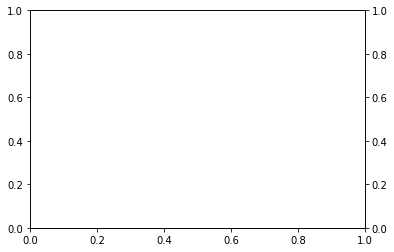

In [4]:
# graph of 'loss' and 'accuracy'
loss_val = list(zip(*loss_val))
acc_val = list(zip(*acc_val))
import matplotlib.ticker as ticker
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(np.array(loss_val[0]), np.array(loss_val[1]), "-r", label="loss")
ax2.plot(np.array(acc_val[0]), np.array(acc_val[1])*100, color="skyblue", label="accurate rate")
ax2.yaxis.set_major_formatter(ticker.FormatStrFormatter("%.2f%%"))
ax1.set_xlabel("epochs")
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
plt.legend(handles1+handles2, labels1+labels2)
plt.title("circle dataset training evaluation")
plt.show()

## 4.测试集上的表现
&emsp;&emsp;to be continued...

## 5.添加正则化项
&emsp;&emsp;to be continued...